## Exploratory Data Analysis

### Import Libraries

In [445]:
import io
import h5py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import viridis
from PIL import Image

In [449]:
# Load HDF5 Data and Decode Images for Processing
hdf5_path = "../dataset/dataset_ca_17.hdf5"

# Define the crop and sensor order as per the mapping
crop_order = [
    "BARLEY", 
    "CANOLA", 
    "CORN", 
    "MIXEDWOOD", 
    "OAT",
    "ORCHARD", 
    "PASTURE", 
    "POTATO", 
    "SOYBEAN", 
    "SPRING_WHEAT"
]
sensors = [
    "RGB",
    "GNDVI", 
    "NDVI", 
    "NDVI45", 
    "OSAVI", 
    "PSRI"
]

### Load and Verify Dataset

In [450]:
# Function to decode an image stored as a variable-length uint8 array
def decode_image(uint8_array, sensor_type):
    if uint8_array.size == 0:
        return None

    # Convert the uint8 numpy array back to bytes
    img_bytes = uint8_array.tobytes()

    try:
        image = Image.open(io.BytesIO(img_bytes))
        # Depending on the sensor type, convert the image appropriately.
        # RGB images are converted to full color.
        if sensor_type == "RGB":
            image = image.convert("RGB")
        # Other sensor types might be encoded as a single channel
        else:
            image = image.convert("L")
        return image
    except Exception as e:
        print(f"Error decoding {sensor_type} image:", e)
        return None

In [451]:
# Load images from the HDF5 file
with h5py.File(hdf5_path, "r") as hf:
    print("Datasets available in the HDF5 file:")
    for key in hf.keys():
        print(f"{key}: {hf[key].shape}")
    
    # Number of records (assuming all metadata arrays have the same length)
    num_records = hf["POINT"].shape[0]
    print("\nTotal number of records:", num_records)
    
    record_idx = random.randint(0, num_records - 1)
    print(f"\nRandomly selected record index: {record_idx}")
    
    # Decode and print details for each sensor image in the random record
    for sensor in sensors:
        sensor_data = hf[sensor][record_idx]
        image = decode_image(sensor_data, sensor)
        if image is not None:
            print(f"{sensor}: decoded image shape = {image.size}, mode = {image.mode}")
        else:
            print(f"{sensor}: No image data or decoding failed.")

Datasets available in the HDF5 file:
CROP_TYPE: (14111,)
DATE: (14111,)
GNDVI: (14111,)
LABEL: (14111,)
NDVI: (14111,)
NDVI45: (14111,)
OSAVI: (14111,)
POINT: (14111,)
PSRI: (14111,)
REGION: (14111,)
RGB: (14111,)

Total number of records: 14111

Randomly selected record index: 10231
RGB: decoded image shape = (65, 65), mode = RGB
GNDVI: decoded image shape = (65, 65), mode = L
NDVI: decoded image shape = (65, 65), mode = L
NDVI45: decoded image shape = (65, 65), mode = L
OSAVI: decoded image shape = (65, 65), mode = L
PSRI: decoded image shape = (65, 65), mode = L


In [452]:
# Load data from HDF5 file
with h5py.File(hdf5_path, 'r') as hf:
    crop_types = hf['CROP_TYPE'][:].astype(str)
    dates = hf['DATE'][:].astype(str)
    points = hf['POINT'][:].astype(str)
    regions = hf['REGION'][:].astype(str)

# Create DataFrame for analysis
df = pd.DataFrame({
    'CROP_TYPE': crop_types,
    'POINT': points,
    'REGION': regions,
    'DATE': dates
})

df.head(5)

CROP_TYPE POINT REGION    DATE
0    BARLEY  1070     ON  201706
1    BARLEY  1070     ON  201707
2    BARLEY  1070     ON  201709
3    BARLEY  1070     ON  201710
4    BARLEY   118     AB  201707

### Crop Distribution Analysis

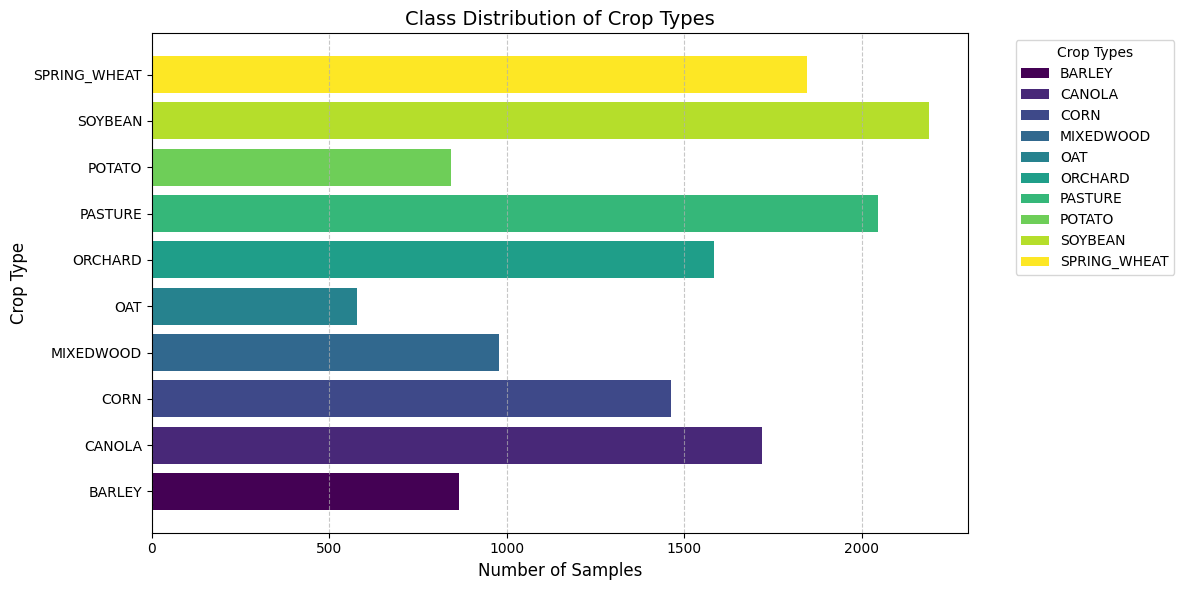

In [453]:
# Count occurrences of each crop type
unique_crops, counts = np.unique(crop_types, return_counts=True)
count_dict = dict(zip(unique_crops, counts))
ordered_counts = [count_dict.get(crop, 0) for crop in crop_order]

# Plot class distribution
plt.figure(figsize=(12, 6))
colors = viridis(np.linspace(0, 1, len(crop_order)))
bars = plt.barh(range(len(crop_order)), ordered_counts, tick_label=crop_order, color=colors)
plt.title('Class Distribution of Crop Types', fontsize=14)
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Crop Type', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add legend outside the plot
plt.legend(bars, crop_order, title='Crop Types', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Temporal Distribution Analysis

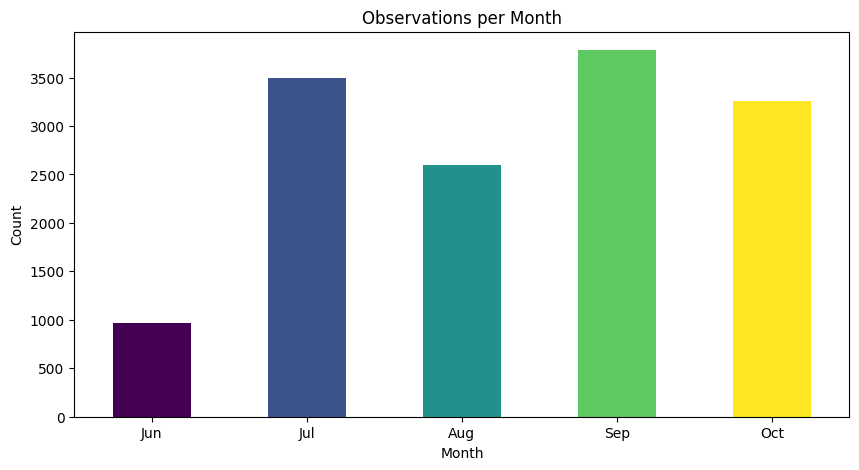

In [454]:
# Convert dates to datetime and format to shortened month name
dates = pd.to_datetime(dates, format='%Y%m')
month_counts = dates.value_counts().sort_index()

# Plot the observation frequency by month using viridis colormap
plt.figure(figsize=(10, 5))
month_counts.index = month_counts.index.strftime('%b')
colors = viridis(np.linspace(0, 1, len(month_counts)))
month_counts.plot(kind='bar', color=colors)
plt.title("Observations per Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

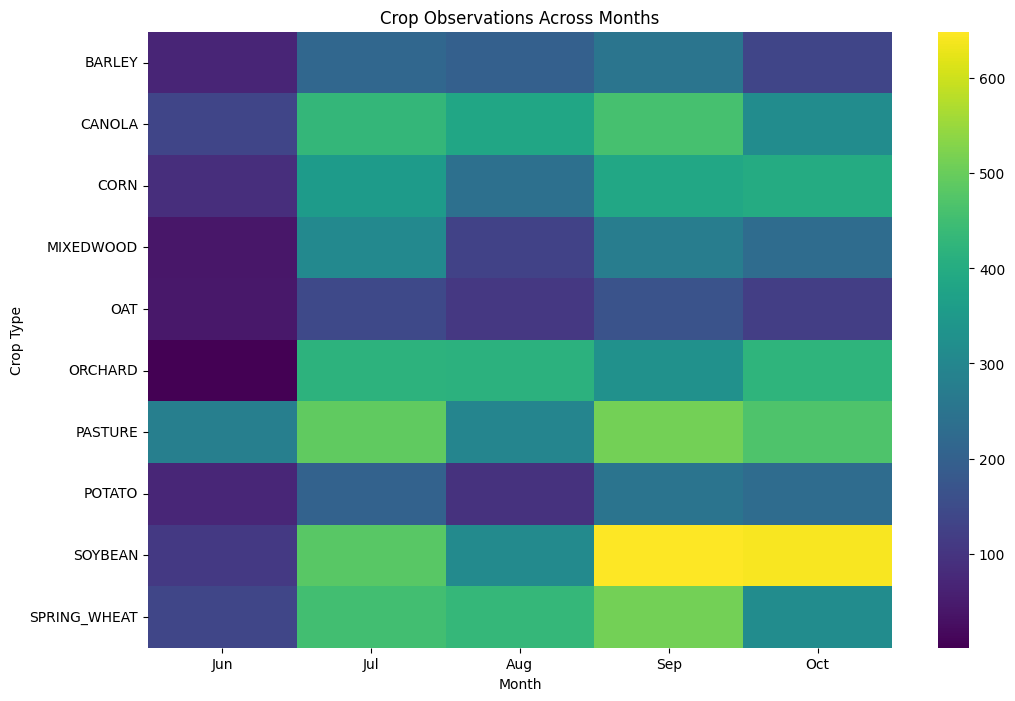

In [455]:
# Temporal distribution per crop
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m').dt.strftime('%b')
month_order = ['Jun', 'Jul', 'Aug', 'Sep', 'Oct']
df['DATE'] = pd.Categorical(df['DATE'], categories=month_order, ordered=True)

crop_month_matrix = pd.crosstab(df['CROP_TYPE'], df['DATE'])

plt.figure(figsize=(12,8))
sns.heatmap(crop_month_matrix, cmap="viridis", annot=False)
plt.title("Crop Observations Across Months")
plt.xlabel("Month")
plt.ylabel("Crop Type")
plt.show()

### Temporal Completeness Analysis

<Figure size 1400x800 with 0 Axes>

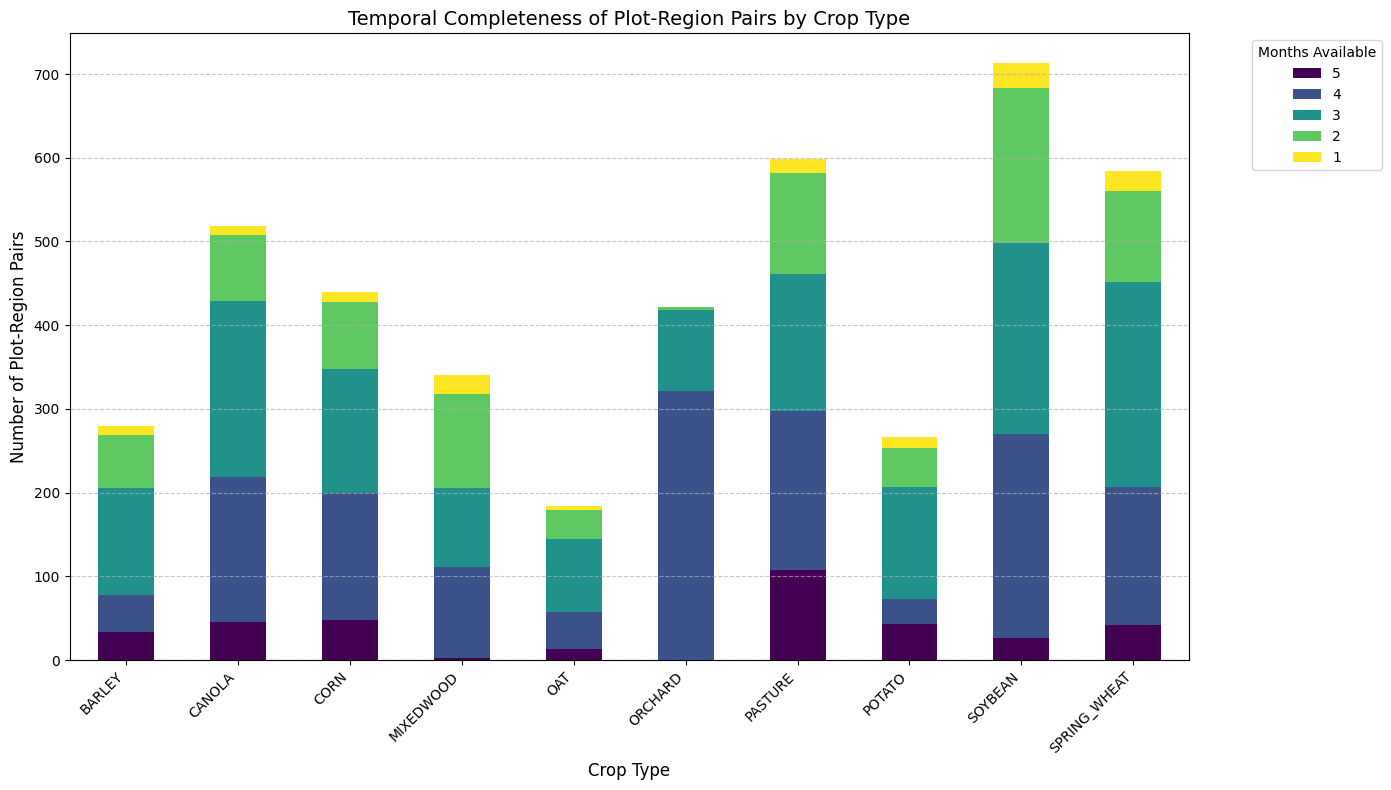

In [456]:
# Initialize summary dataframe
completeness_levels = [5, 4, 3, 2, 1]
summary = pd.DataFrame(index=crop_order, columns=completeness_levels, dtype=int)

# Calculate completeness for each crop
for crop in crop_order:
    crop_df = df[df['CROP_TYPE'] == crop]
    if crop_df.empty:
        summary.loc[crop] = 0
        continue
    
    grouped = crop_df.groupby(['POINT', 'REGION'])['DATE'].nunique().reset_index(name='NUM_DATES')
    date_counts = grouped['NUM_DATES'].value_counts().reindex(completeness_levels, fill_value=0)
    summary.loc[crop] = date_counts.values

# Visualize temporal completeness
plt.figure(figsize=(14, 8))
colors = viridis(np.linspace(0, 1, len(completeness_levels)))
summary.sort_index(axis=1, ascending=False).plot(kind='bar', stacked=True, color=colors, figsize=(14, 8))

plt.title('Temporal Completeness of Plot-Region Pairs by Crop Type', fontsize=14)
plt.xlabel('Crop Type', fontsize=12)
plt.ylabel('Number of Plot-Region Pairs', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Months Available', labels=[f'{l}' for l in completeness_levels], 
          bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [457]:
# Display numerical summary
print("\nTemporal Completeness Summary (Number of Plot-Region Pairs):")
display(summary.style.background_gradient(cmap='viridis', axis=1))


Temporal Completeness Summary (Number of Plot-Region Pairs):


### Geospatial Analysis

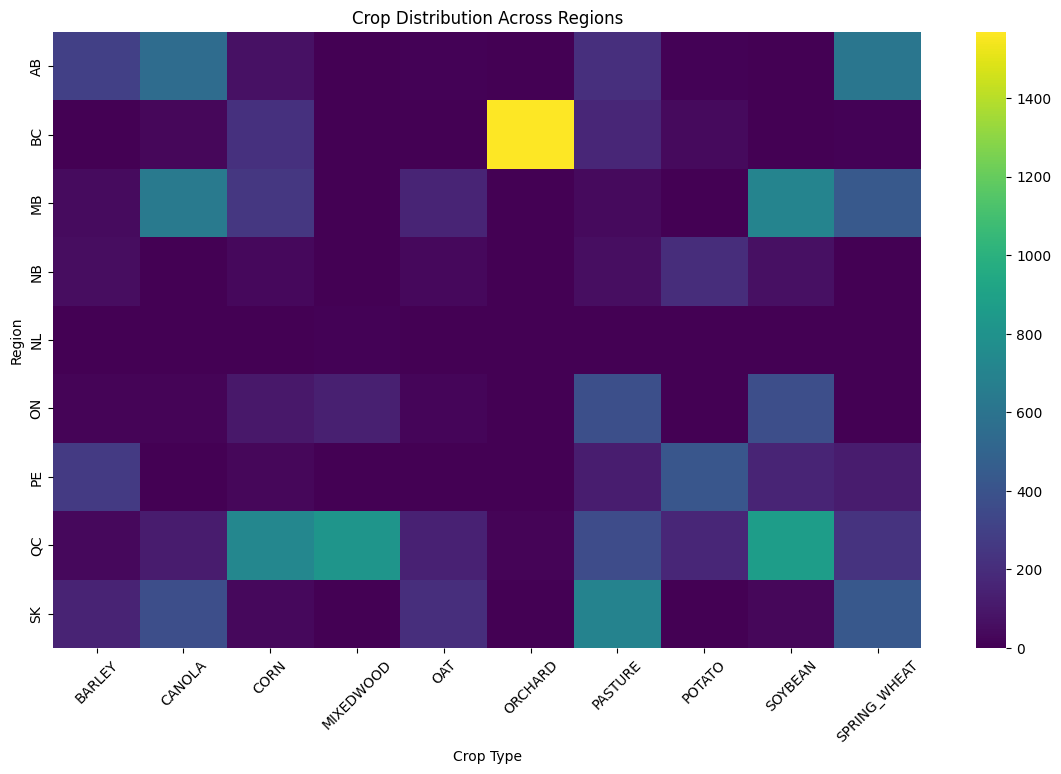

In [458]:
# Plot regional distribution of crops
region_crop_counts = pd.crosstab(df['REGION'], df['CROP_TYPE'])
plt.figure(figsize=(14,8))
sns.heatmap(region_crop_counts, cmap="viridis", annot=False)
plt.title("Crop Distribution Across Regions")
plt.xlabel("Crop Type")
plt.ylabel("Region")
plt.xticks(rotation=45)
plt.show()

# Plot coordinates on a map (if coordinates exist)
if "POINT" in hf.keys():
    coords = [eval(pt) for pt in df['POINT']]
    lats = [c[0] for c in coords]
    lons = [c[1] for c in coords]
    
    plt.figure(figsize=(10,8))
    plt.scatter(lons, lats, c=pd.Categorical(df['CROP_TYPE']).codes, cmap='tab20', alpha=0.6)
    plt.colorbar(label='Crop Type')
    plt.title("Geospatial Distribution of Samples")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

### Image Statistics Analysis

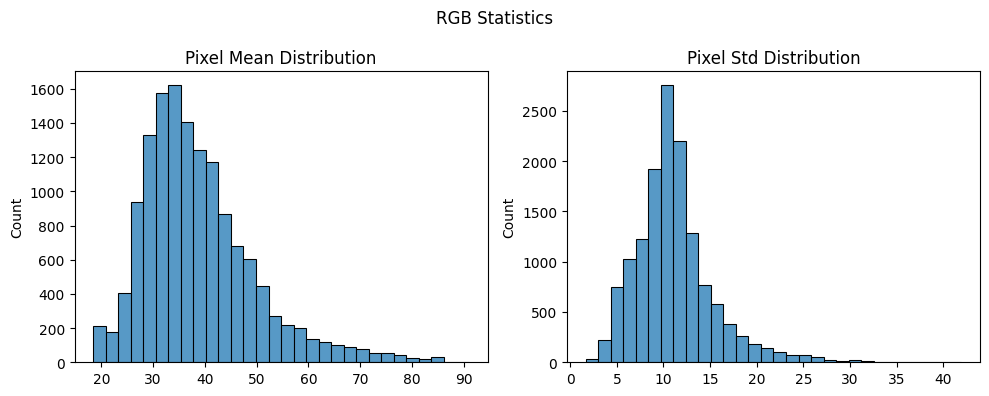

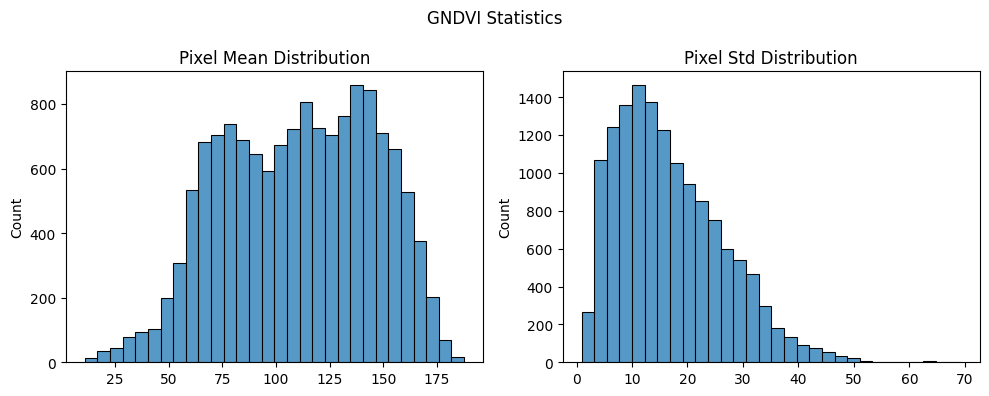

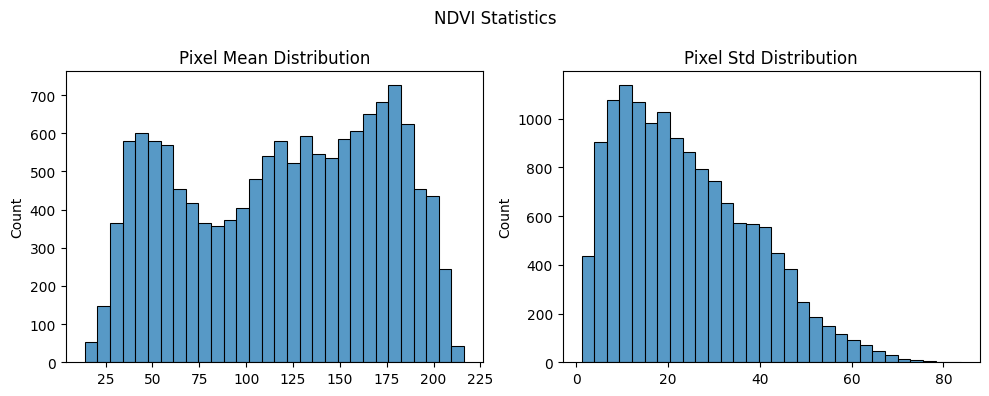

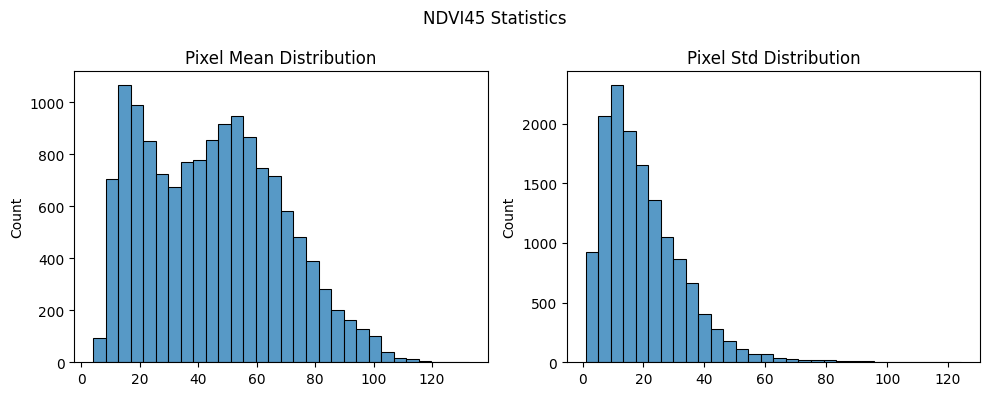

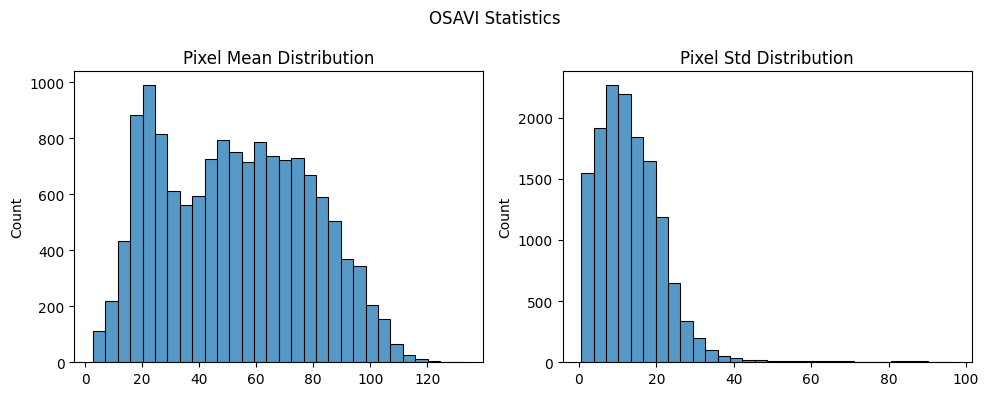

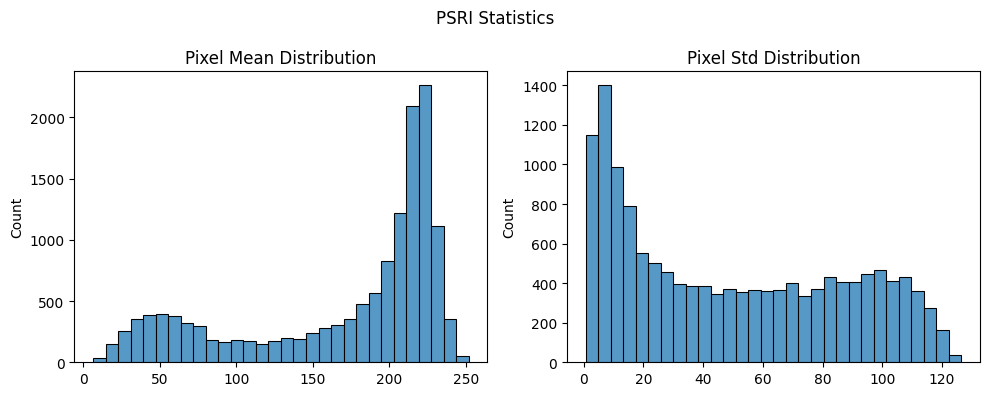

In [459]:
def analyze_sensor_stats(sensor):
    with h5py.File(hdf5_path, "r") as hf:
        means, stds = [], []
        for arr in hf[sensor]:
            if len(arr) > 0:
                img = decode_image(arr, sensor)
                means.append(np.mean(img))
                stds.append(np.std(img))
    
    plt.figure(figsize=(10,4))
    plt.suptitle(f"{sensor} Statistics")
    plt.subplot(121)
    sns.histplot(means, bins=30)
    plt.title("Pixel Mean Distribution")
    plt.subplot(122)
    sns.histplot(stds, bins=30)
    plt.title("Pixel Std Distribution")
    plt.tight_layout()

for sensor in sensors:
    analyze_sensor_stats(sensor)

### Cross-Sensor Correlation Analysis

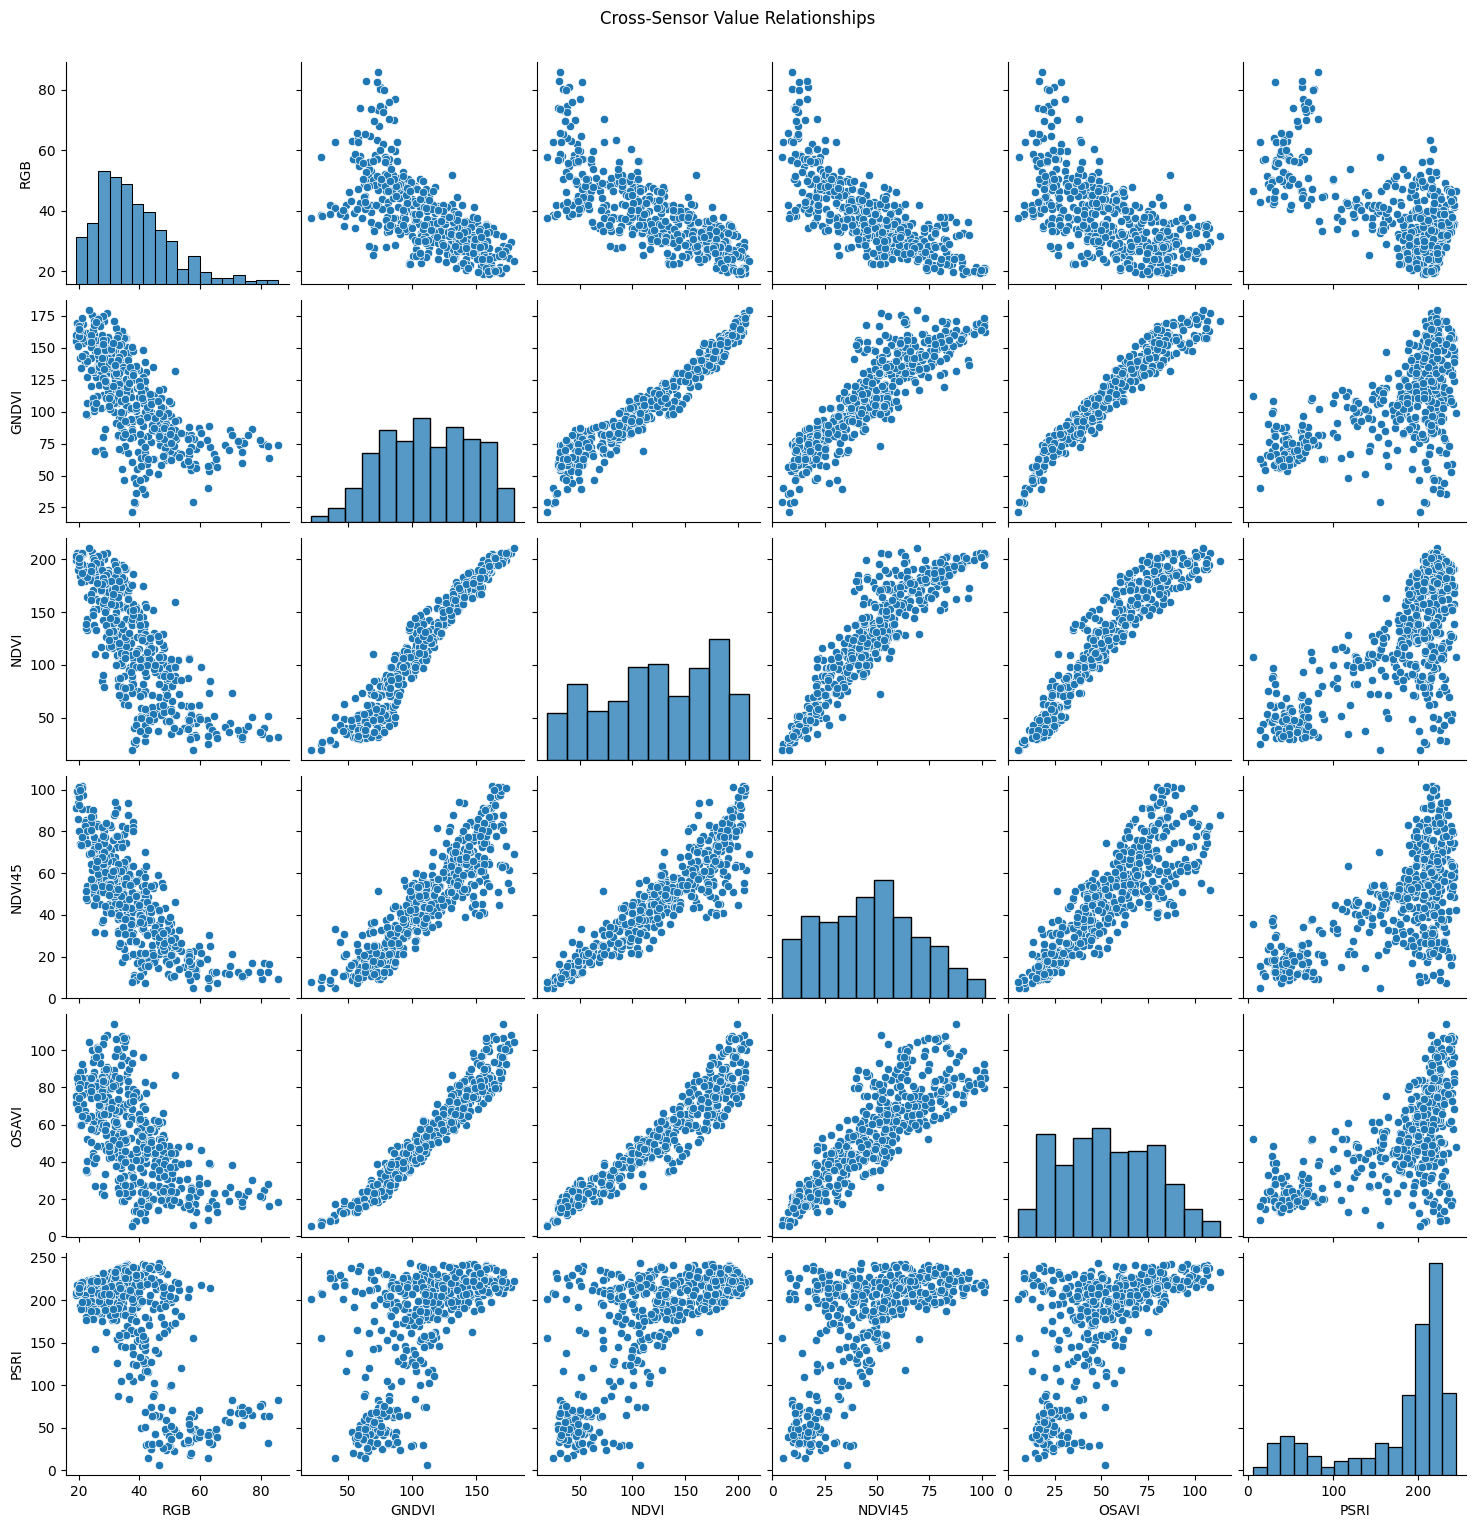

In [460]:
# Calculate correlation between sensor values
def get_sensor_values(sensor, num_samples=1000):
    with h5py.File(hdf5_path, "r") as hf:
        samples = [np.mean(decode_image(arr, sensor)) 
                 for arr in hf[sensor][:num_samples] if len(arr) > 0]
    return samples

sensor_data = {}
for sensor in sensors:
    sensor_data[sensor] = get_sensor_values(sensor)

df_sensors = pd.DataFrame(sensor_data)
sns.pairplot(df_sensors.sample(500))
plt.suptitle("Cross-Sensor Value Relationships", y=1.02)
plt.show()

### Sensor Outputs for each Crop Type

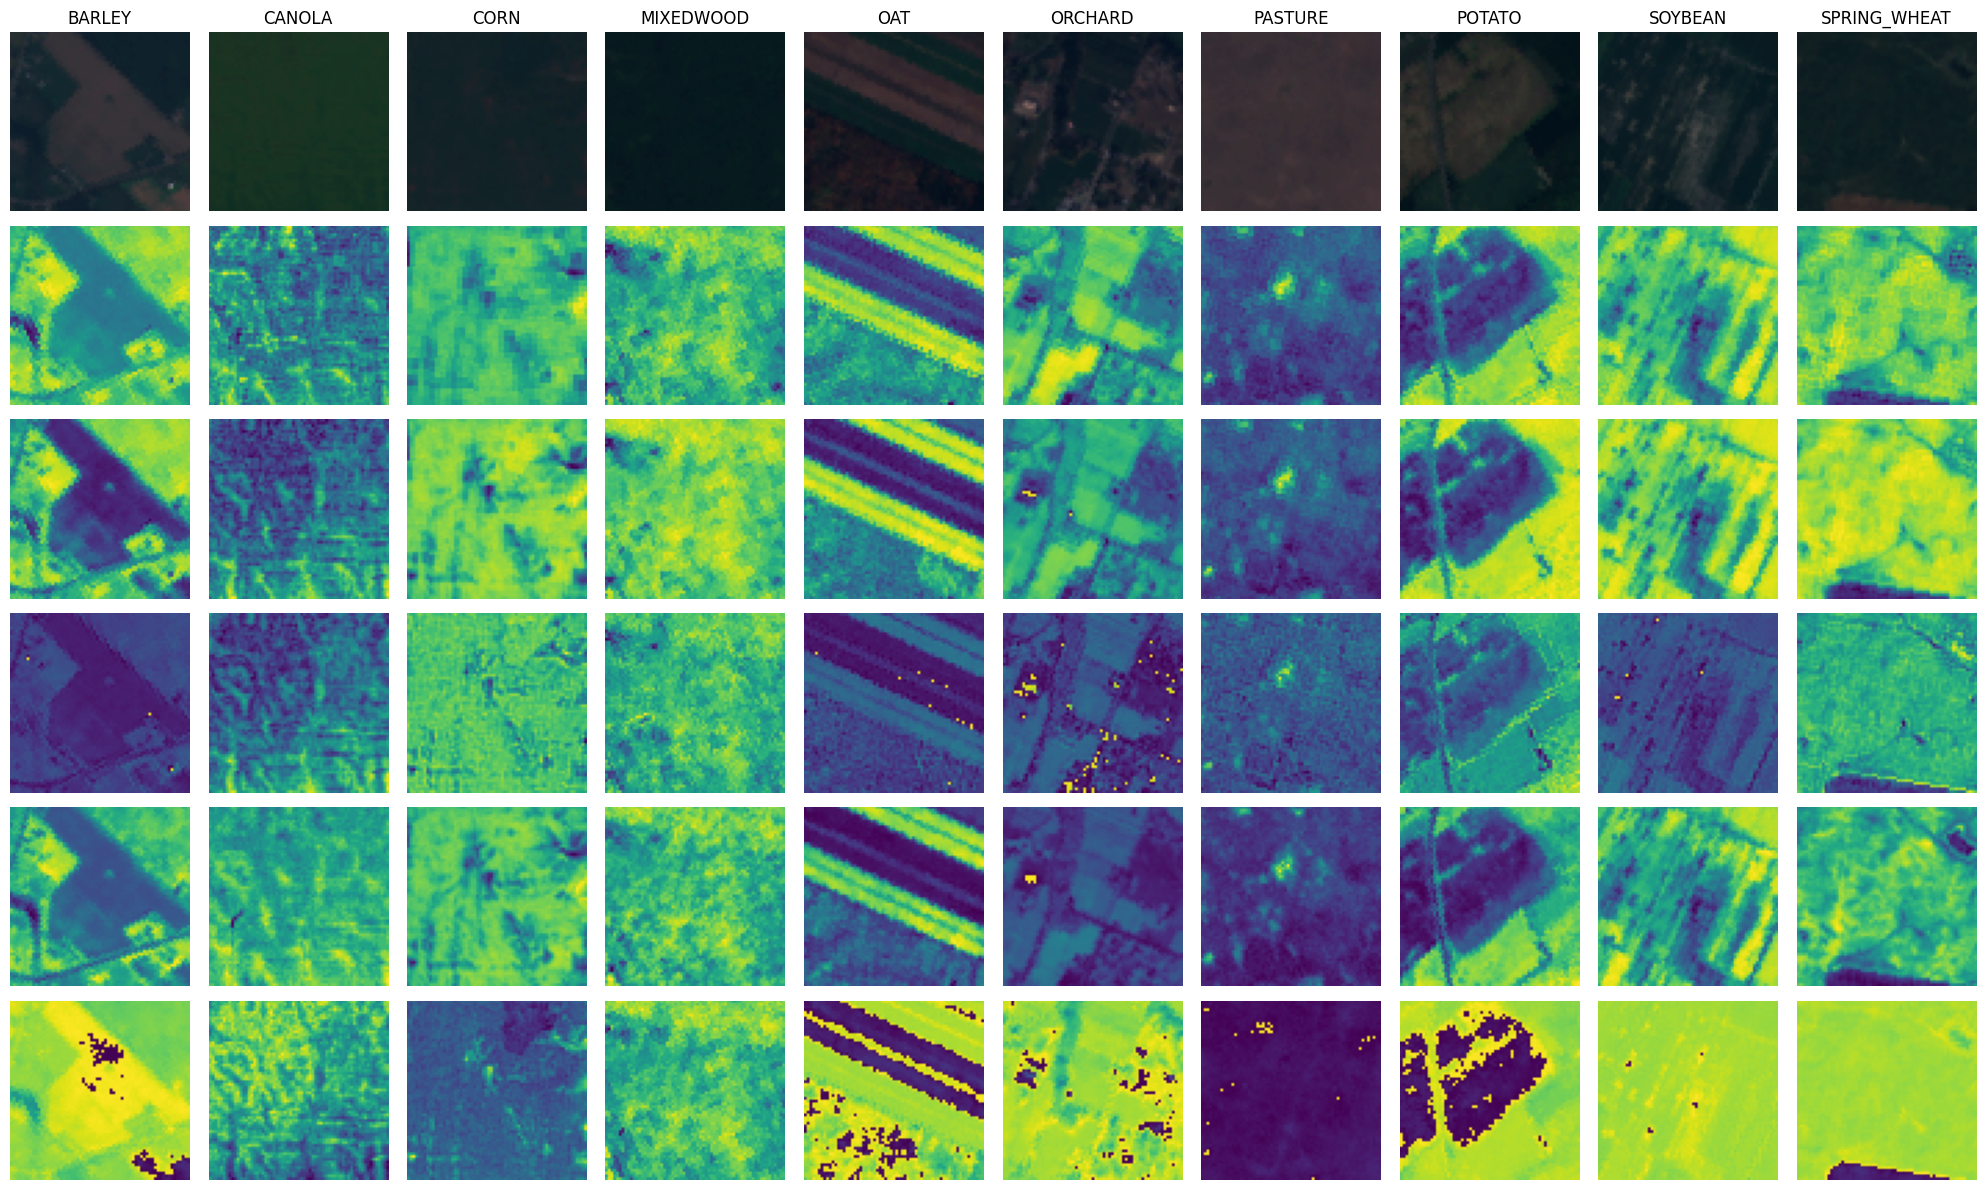

In [461]:
# Select one random sample for each crop type
# key: crop type, value: record index
selected_samples = {}

# For each crop, choose one random sample if available
for crop in crop_order:
    indices = np.where(crop_types == crop)[0]
    if len(indices) > 0:
        selected_samples[crop] = random.choice(indices)
    else:
        print(f"No samples found for crop: {crop}")

# Create a grid: rows = sensor types, columns = crop types
fig, axes = plt.subplots(nrows=len(sensors), ncols=len(crop_order), figsize=(20, 12))

# Open the HDF5 file
with h5py.File(hdf5_path, "r") as hf:
    # Loop over each sensor (row) and each crop (column)
    for row, sensor in enumerate(sensors):
        for col, crop in enumerate(crop_order):
            ax = axes[row, col]
            ax.axis("off")
            ax.set_aspect('equal')
            # Get the record index for this crop type
            if crop in selected_samples:
                idx = selected_samples[crop]
                sensor_data = hf[sensor][idx]
                image = decode_image(sensor_data, sensor)
                if image is not None:
                    ax.imshow(image)
                else:
                    ax.text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=10)
            else:
                ax.text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=10)
            # Set the crop label on the top row
            if row == 0:
                ax.set_title(crop, fontsize=12)
        # Label the sensor type on the left of each row
        axes[row, 0].set_ylabel(sensor, fontsize=12, rotation=90, labelpad=10, va="center")

plt.tight_layout()
plt.show()

### Crop Change Over Time

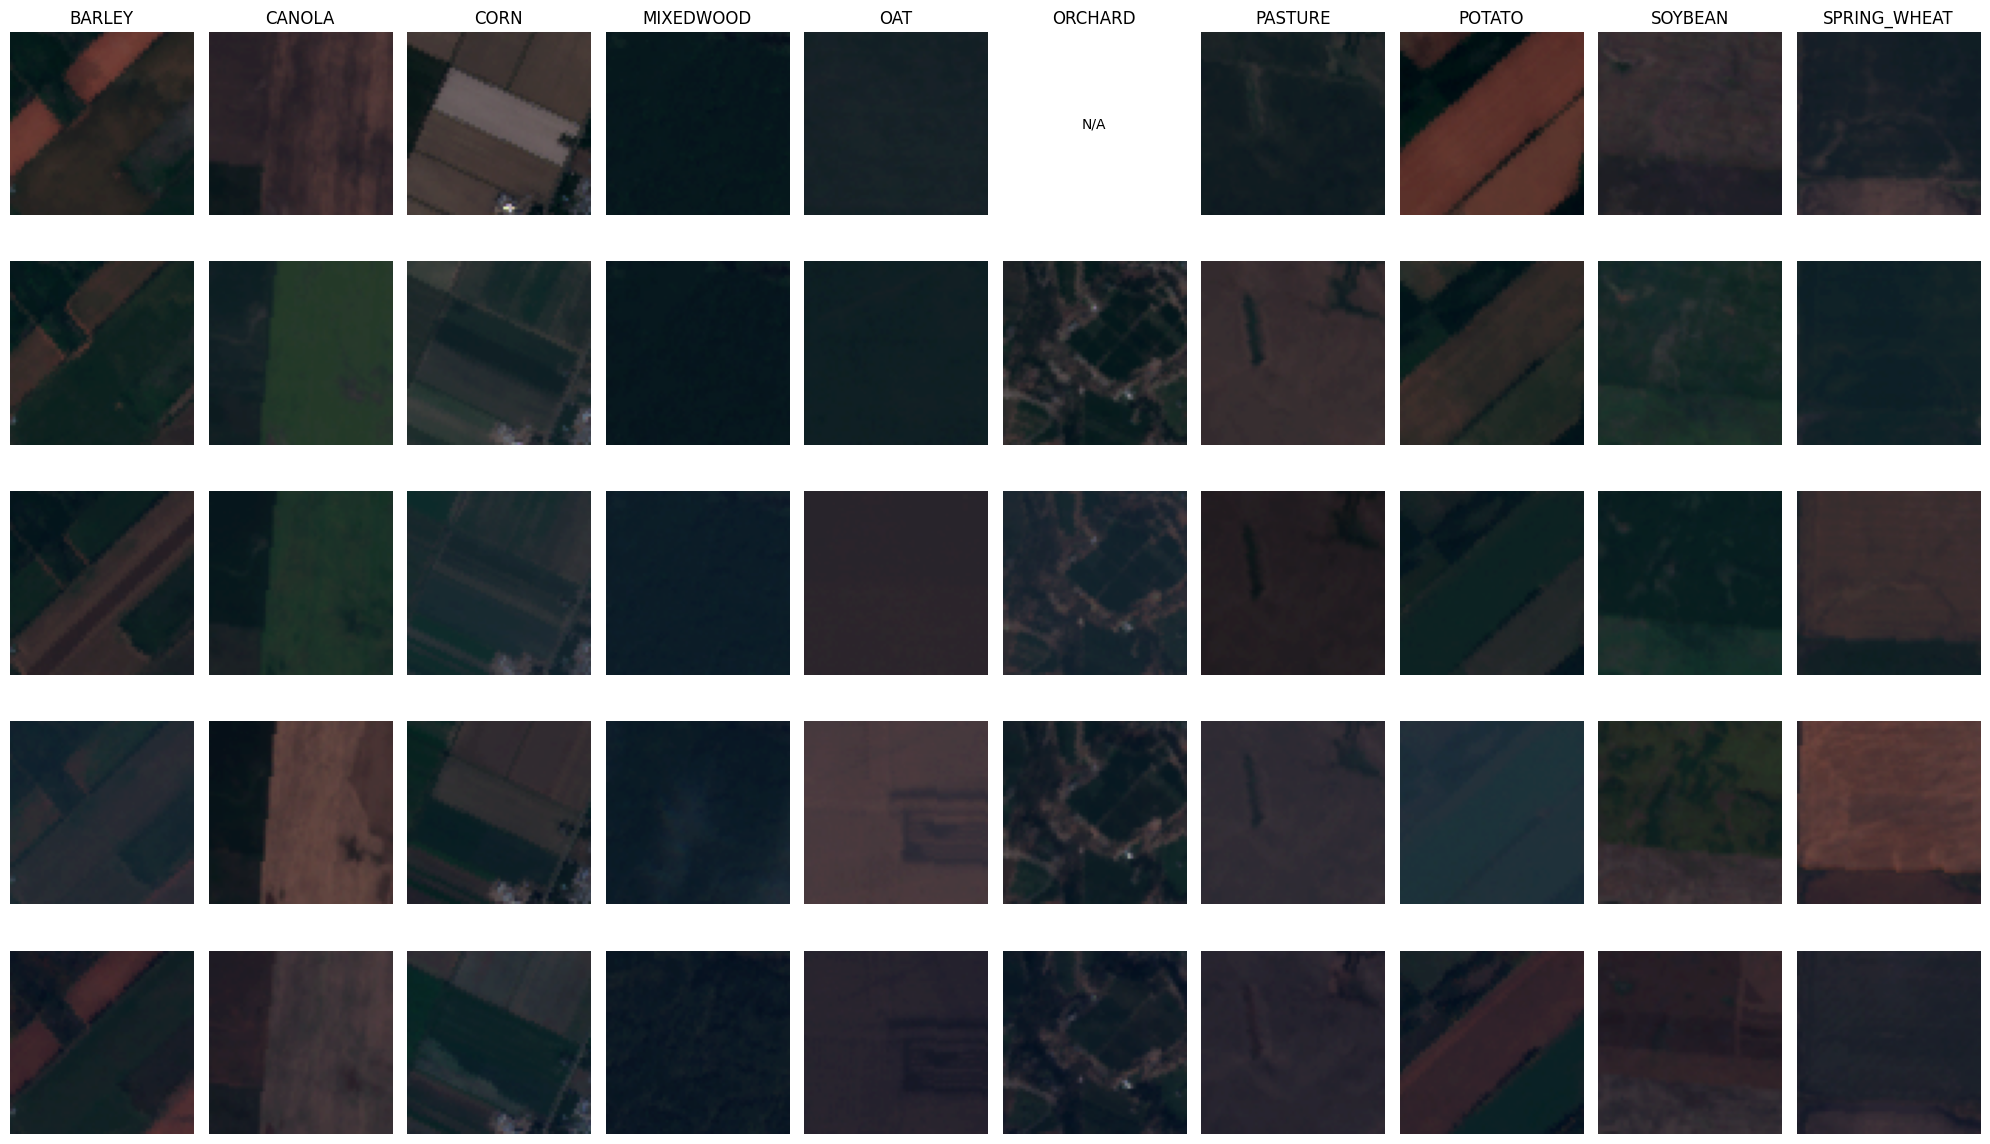

In [466]:
date_range = pd.date_range(start="2017-06-01", end="2017-10-31", freq='MS')
date_labels = date_range.strftime('%Y%m')

with h5py.File(hdf5_path, "r") as hf:
    crop_types = np.array(hf["CROP_TYPE"][:], dtype=str)
    dates = np.array(hf["DATE"][:], dtype=str)
    points = np.array(hf["POINT"][:], dtype=str)
    regions = np.array(hf["REGION"][:], dtype=str)
    
    fig, axes = plt.subplots(nrows=len(date_labels), ncols=len(crop_order), figsize=(20, 12))
    
    for col, crop in enumerate(crop_order):
        crop_indices = np.where(crop_types == crop)[0]
        if len(crop_indices) == 0:
            # Handle no data for crop
            continue
        
        # Find all unique (point, region) pairs for this crop
        unique_pairs = set(zip(points[crop_indices], regions[crop_indices]))
        valid_pairs = []
        
        # Check which pairs have data for all dates
        for (point, region) in unique_pairs:
            has_all_dates = all(
                any((points == point) & (regions == region) & (dates == dl) & (crop_types == crop))
                for dl in date_labels
            )
            if has_all_dates:
                valid_pairs.append((point, region))
        
        # Select a valid pair if available, else any pair
        if valid_pairs:
            selected_point, selected_region = random.choice(valid_pairs)
        else:
            # Fallback: select any pair (may have missing dates)
            selected_idx = random.choice(crop_indices)
            selected_point = points[selected_idx]
            selected_region = regions[selected_idx]
        
        # Plot each date
        for row, date_label in enumerate(date_labels):
            ax = axes[row, col]
            ax.axis("off")
            ax.set_aspect('equal')
            if row == 0:
                ax.set_title(crop, fontsize=12)
            if col == 0:
                ax.set_ylabel(date_label, fontsize=12, rotation=90, labelpad=10, va="center")
            
            # Find matching index for selected label, region, date, and crop
            mask = (
                (points == selected_point) & 
                (regions == selected_region) & 
                (dates == date_label) & 
                (crop_types == crop)
            )
            matching_indices = np.where(mask)[0]
            
            if matching_indices.size > 0:
                idx = matching_indices[0]
                img_data = hf["RGB"][idx]
                image = decode_image(img_data, "RGB")
                ax.imshow(image) if image is not None else ax.text(0.5, 0.5, "N/A", ha="center", va="center")
            else:
                ax.text(0.5, 0.5, "N/A", ha="center", va="center")
    
    plt.tight_layout()
    plt.show()